# Tensorflow 2.3.1: Generative Adversarial Networks 

This Notebook has been based on three Tensorflow Tutorials convering 3 separate topics. I put them all here together to better understand GANs with color images

* [DCGAN with MNIST](https://www.tensorflow.org/tutorials/generative/dcgan)
* [Artifical Faces with GAN and tf_gan](https://www.tensorflow.org/hub/tutorials/tf_hub_generative_image_module)
* [GAN for Small Color Photographs](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/)

PLACEHOLDER FOR INTRODUCTION TEXT

PLACEHOLDER FOR WHERE THE DATA CAME FROM

PLACEHOLDER FOR WHERE I GOT THE DATA

PLACEHOLDER FOR TABLE OF CONTENTS

# Imports

In [60]:
#import the neccessary libraries
import pickle as pkl
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import numpy as np
import pathlib
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, LeakyReLU, Reshape, Conv2DTranspose
from tensorflow.keras import layers
from tensorflow.keras import Input

In [69]:
tf.__version__

'2.3.1'

Let's add a relative filepath and an absolute filepath:

In [5]:
filepath = 'data/celeba'

In [6]:
data_dir = pathlib.Path(filepath).absolute()

In [7]:
data_dir

PosixPath('/data/capstone/gnn-examples/scratch_gnn_example/data/celeba')

Let's get a filelist:

In [9]:
filelist = [str(i) for i in list(data_dir.glob('*.jpg'))]

In [10]:
filelist[0]

'/data/capstone/gnn-examples/scratch_gnn_example/data/celeba/180560.jpg'

Let's see what kind of pictures we are working with: 

# Exploratory Data Visualization

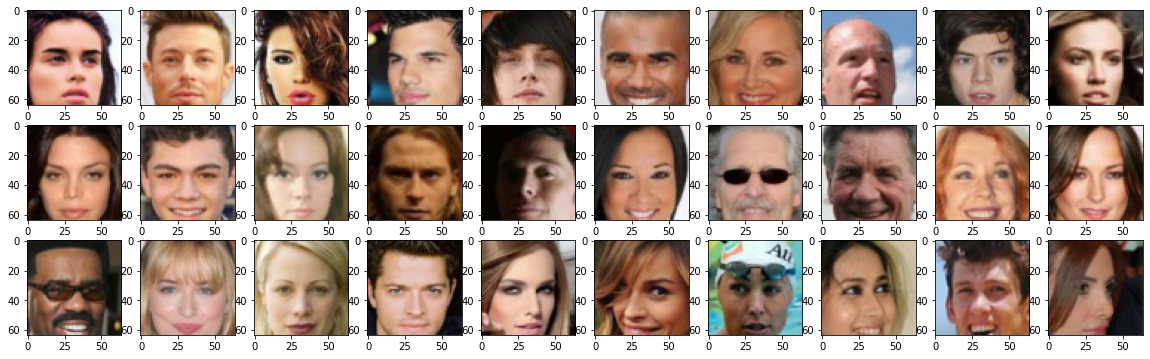

In [11]:
plt.figure(figsize=(20, 6))
for i in range(30):
    plt.subplot(3, 10,i+1)
    plt.imshow(PIL.Image.open(np.random.choice(filelist)))

Another method of showing images using matplotlib:

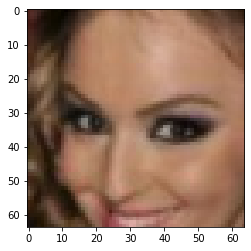

In [13]:
plt.imshow(plt.imread(filelist[0]))

If we are going to load this data into a TF neural network, it needs to be wrapped in a tensorflow data loader:

In [66]:
def decode_img(img_path):
    '''
    Convert a string filepath into a TF tensor
    '''
    img_path = tf.convert_to_tensor(img_path, dtype=tf.string)
    return tf.image.decode_jpeg(tf.io.read_file(img_path))

In [15]:
test = decode_img(filelist[0])

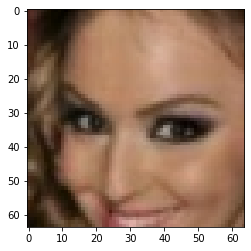

In [16]:
plt.imshow(test)

In [17]:
type(test)

tensorflow.python.framework.ops.EagerTensor

In [18]:
test.shape

TensorShape([64, 64, 3])

Alright our simple image dataloader works! Let's put it into a batcher so we can lazy load 128 at a time

# Dataloading

In [20]:
dataset = (decode_img(i) for i in filelist)

In [21]:
sample_data = [next(dataset) for i in range(100)]

We've created a tensorflow generator that represents all of the image files we have identified from producing a filelist, because I want to be able to replicate this on as many machines as possible which may not have my own specifications

Here we've maade a 64 x 64 color image generator. It is untrained so it will make no sense. That's okay!

# Discriminator and Generator Neural Networks

In [24]:
# define the standalone generator model
def make_generator_model(latent_dim):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 64x64
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

In [76]:
latent_dim = 100 # vector of random numbers from a normal distribution

generator = make_generator_model(latent_dim)

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
converted_output = ((generated_image + 1) / 2) # move values from [-1, 1,] to [0, 1]

In [77]:
converted_output.shape

TensorShape([1, 64, 64, 3])

Text(0.5, 0.98, '3 Channel Generated Imaged with Combined Color Image')

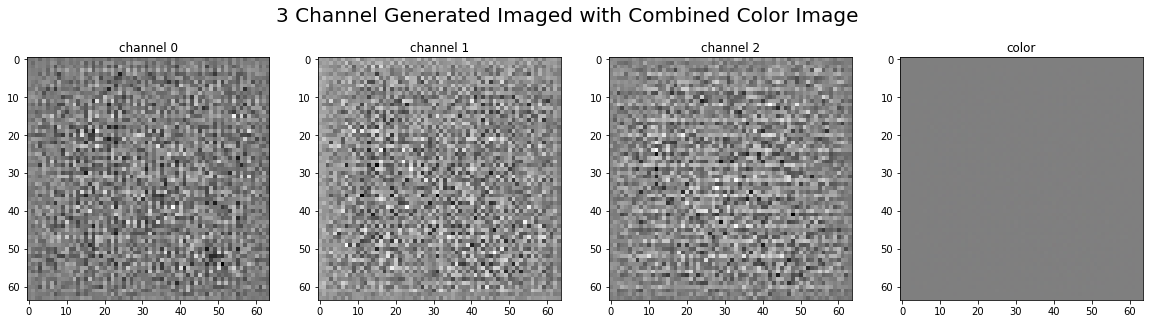

In [87]:
plt.figure(figsize=(20, 5))

for i in range(0,3):
    plt.subplot(1,4,i+1)
    plt.imshow(converted_output[0,:,:,i], cmap='gray')
    plt.title(f'channel {i}')

plt.subplot(1,4,4)
plt.imshow(converted_output[0,:,:,:])
plt.title('color');
plt.suptitle('3 Channel Generated Imaged with Combined Color Image', fontsize=20)

Neat, our generator is able to make 64x64 color images. Right now it sure doesn't mean anything but hey ! 

In [35]:
def make_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3])) 
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [44]:
discriminator = make_discriminator()

In [45]:
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)            

In [49]:
decision = discriminator(generated_image)
decision, np.average(decision)

(<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
 array([[-0.00017954],
        [ 0.00094348],
        [ 0.00024291]], dtype=float32)>,
 0.00033561327)

So looking at these numbers, we have a set of predictions from our discriminator, our CNN.

It evaluates each channel as a separate image, but we can consider the average of the 3 numbers as the overall prediction

The higher the number the more "real"

The lower the number the more "fake"

The closer to 0, the more unsure our network is 

# Discriminator and Generator Losses

In order for our neural networks to start being adversarial to each other, we are going to need to setup two losses, one for each network respectitely

In [51]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [52]:
# This one will define how well our discriminator does by classifying images, real from fake.

# So our discriminator is just a well trained classification neural network. If we had wanted to, instead of using our own small model we could use
# ImageNet as our discriminator, because it is pretrained and already knows objects.

# It compares the predictions of the discriminator to the ground truth of
# real pictures are 1
# fake pictures are 0

In [53]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [54]:
# The generator's loss is just a measure of how well it can trick the discriminator

# If fake images are seen as real images = 1
# if fake images are seen as fake images = 0

In [55]:
# Let's set up the two optimizers

In [56]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [57]:
# After we have set up all of the definitions, let's also set up a 
# checkpoint system so we can return to a previous epoch or load a new model and contuine training

In [61]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [62]:
# Let's set up a training loop so we can execute one instance of the generator making an image and the discrimiator classifying the image as real or fake

In [63]:
# Our hyperparameters

In [64]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim]) 

https://www.tensorflow.org/api_docs/python/tf/GradientTape

Gradient tape records operations for automatic differntiation. This automatically computs the gradient of a computation with respect to the inputs
 
https://en.wikipedia.org/wiki/Automatic_differentiation

Automatic differentiation is a set of techniques to numerically evaluate the deriverate of a function. In the case of the neural networks, we are finding the local minima and maxima of the linear equations with respect to the neural network

We do NOT want to be manually calculating the deriverative of each equation, of each step. so this is a convieneance function provided by tensorflow

the general idea on how Autodifferentiation works is as seen:

In [65]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".

@tf.function

# This is equivalent to doing model.compile()

def train_step(images):
    
    # set up random noise to be input into the GAN
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))